In [13]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
import sys

sys.path.append("..")

---

In [50]:
import json
from functools import partial

import pandas as pd
import sklearn
import numpy as np
import seaborn as sns

from funcs.utils import find_project_root

from resources.nlp_models import load_scispacy_lg
from scripts.clean_epigraphdb_ents import clean_text

In [4]:
root = find_project_root()
data_dir = root.parent / "data"
assert data_dir.exists()
ebi_dir = data_dir / "gwas-catalog"
gwas_to_efo_path = ebi_dir / "clean_gwas_to_efo.csv"
assert gwas_to_efo_path.exists()

---

# Encode

In [7]:
nlp = load_scispacy_lg()

2021-06-10 15:05:05.800 | INFO     | funcs.utils:timed:35 - load_scispacy_lg finished in 0.23 mins.


In [10]:
gwas_to_efo = pd.read_csv(gwas_to_efo_path)
print(gwas_to_efo.info())
gwas_to_efo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16871 entries, 0 to 16870
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gwas_name        16871 non-null  object
 1   efo_name         16871 non-null  object
 2   efo_id           16871 non-null  object
 3   parent_efo_name  16871 non-null  object
 4   parent_efo_id    16871 non-null  object
dtypes: object(5)
memory usage: 659.1+ KB
None


,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444


In [19]:
def encode(text: str, nlp_model) -> str:
    doc = nlp_model(text)
    if doc.vector is not None:
        return doc.vector.tolist()
    else:
        return []

In [26]:
%%time

gwas_encodes = (
    gwas_to_efo[["gwas_name"]]
    .drop_duplicates()
    .assign(
        clean_text=lambda df: df["gwas_name"].apply(
            lambda x: clean_text(x, nlp_model=nlp)
        )
    )
    .assign(
            vector=lambda df: df["clean_text"].apply(lambda x: encode(x, nlp_model=nlp))
        )
)
print(gwas_encodes.info())
gwas_encodes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13334 entries, 0 to 16870
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gwas_name   13334 non-null  object
 1   clean_text  13334 non-null  object
 2   vector      13334 non-null  object
dtypes: object(3)
memory usage: 416.7+ KB
None
CPU times: user 1min 52s, sys: 280 ms, total: 1min 52s
Wall time: 1min 52s


,gwas_name,clean_text,vector
0,Clubfoot,clubfoot,"[-0.37584900856018066, 0.19428400695323944, -0..."
1,Alcohol dependence or heroin dependence or met...,alcohol dependence or heroin dependence or met...,"[-0.11215012520551682, -0.17538602650165558, 0..."
2,Methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,Hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,Age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."


In [27]:
output_file = ebi_dir / "gwas_encodes.csv.gz"
gwas_encodes.to_csv(output_file, index=False, compression="gzip")

In [31]:
%%time

efo_encodes = (
    gwas_to_efo[["efo_id", "efo_name"]]
    .drop_duplicates()
    .assign(
        clean_text=lambda df: df["efo_name"].apply(
            lambda x: clean_text(x, nlp_model=nlp)
        )
    )
    .assign(
            vector=lambda df: df["clean_text"].apply(lambda x: encode(x, nlp_model=nlp))
        )
)
print(efo_encodes.info())
efo_encodes.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2761 entries, 0 to 16869
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   efo_id      2761 non-null   object
 1   efo_name    2761 non-null   object
 2   clean_text  2761 non-null   object
 3   vector      2761 non-null   object
dtypes: object(4)
memory usage: 107.9+ KB
None
CPU times: user 21.2 s, sys: 104 ms, total: 21.3 s
Wall time: 21.3 s


,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
9,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."


In [32]:
output_file = ebi_dir / "efo_encodes.csv.gz"
efo_encodes.to_csv(output_file, index=False, compression="gzip")

---

# similarity score

In [47]:
gwas_arr = np.stack(np.array(gwas_encodes["vector"].tolist()), axis=0)
print(gwas_arr.shape)
assert gwas_arr[0, :].tolist() == gwas_encodes["vector"][0]

(13334, 200)


In [48]:
efo_arr = np.stack(np.array(efo_encodes["vector"].tolist()), axis=0)
print(efo_arr.shape)
assert efo_arr[0, :].tolist() == efo_encodes["vector"][0]

(2761, 200)


In [54]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine as cosine_distance

In [53]:
%%time

similarity_arr = cosine_similarity(gwas_arr, efo_arr)
print(similarity_arr.shape)

(13334, 2761)
CPU times: user 4min 27s, sys: 12min 34s, total: 17min 1s
Wall time: 31.4 s


In [56]:
print(similarity_arr[0, 0])
print(1 - cosine_distance(gwas_encodes["vector"][0], efo_encodes["vector"][0],))

0.5734677237334654
0.5734677237334653


In [57]:
output_file = ebi_dir / "similarity_arr.npy"
np.save(output_file, similarity_arr)

---

# eval

In [5]:
gwas_encodes_path = ebi_dir / "gwas_encodes.csv.gz"
efo_encodes_path = ebi_dir / "efo_encodes.csv.gz"
gwas_to_efo_path = ebi_dir / "clean_gwas_to_efo.csv"
similarity_arr_path = ebi_dir / "similarity_arr.npy"

In [6]:
gwas_to_efo = pd.read_csv(gwas_to_efo_path)
print(gwas_to_efo.info())
gwas_to_efo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16871 entries, 0 to 16870
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   gwas_name        16871 non-null  object
 1   efo_name         16871 non-null  object
 2   efo_id           16871 non-null  object
 3   parent_efo_name  16871 non-null  object
 4   parent_efo_id    16871 non-null  object
dtypes: object(5)
memory usage: 659.1+ KB
None


,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444


In [7]:
gwas_encodes = pd.read_csv(gwas_encodes_path).assign(
    vector=lambda df: df["vector"].apply(json.loads)
)
print(gwas_encodes.info())
gwas_encodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13334 entries, 0 to 13333
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gwas_name   13334 non-null  object
 1   clean_text  13334 non-null  object
 2   vector      13334 non-null  object
dtypes: object(3)
memory usage: 312.6+ KB
None


,gwas_name,clean_text,vector
0,Clubfoot,clubfoot,"[-0.37584900856018066, 0.19428400695323944, -0..."
1,Alcohol dependence or heroin dependence or met...,alcohol dependence or heroin dependence or met...,"[-0.11215012520551682, -0.17538602650165558, 0..."
2,Methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
3,Hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
4,Age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."


In [8]:
efo_encodes = pd.read_csv(efo_encodes_path).assign(
    vector=lambda df: df["vector"].apply(json.loads)
)
print(efo_encodes.info())
efo_encodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2761 entries, 0 to 2760
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   efo_id      2761 non-null   object
 1   efo_name    2761 non-null   object
 2   clean_text  2761 non-null   object
 3   vector      2761 non-null   object
dtypes: object(4)
memory usage: 86.4+ KB
None


,efo_id,efo_name,clean_text,vector
0,http://www.orpha.net/ORDO/Orphanet_199315,familial clubfoot with or without associated l...,familial clubfoot with or without associate lo...,"[-0.02324697934091091, 0.004608644172549248, -..."
1,http://www.ebi.ac.uk/efo/EFO_0004701,methamphetamine dependence,methamphetamine dependence,"[-0.22024500370025635, -0.18752296268939972, 0..."
2,http://www.ebi.ac.uk/efo/EFO_0004705,hypothyroidism,hypothyroidism,"[-0.10238999873399734, 0.3485580086708069, 0.1..."
3,http://www.ebi.ac.uk/efo/EFO_0004704,age at menopause,age at menopause,"[-0.09575866907835007, -0.008548134006559849, ..."
4,http://www.ebi.ac.uk/efo/EFO_0004703,age at menarche,age at menarche,"[-0.12539799511432648, -0.04193533584475517, -..."


In [9]:
similarity_arr = np.load(similarity_arr_path)

In [10]:
similarity_arr.shape

(13334, 2761)

In [11]:
print(similarity_arr)

[[ 0.57346772 -0.08321398  0.43528596 ...  0.14525737  0.25932941
   0.06446416]
 [ 0.15219263  0.92250771  0.10776712 ...  0.02089715 -0.01034494
   0.15754692]
 [ 0.00778261  1.          0.08975805 ...  0.03561883 -0.03105269
   0.16007295]
 ...
 [ 0.11294115  0.07792424  0.21593123 ... -0.00859792 -0.07831833
   0.03265154]
 [ 0.24552335  0.11146804  0.31138856 ...  0.15902792  0.08289844
   0.16645138]
 [ 0.19952689  0.18990634  0.14023943 ...  0.1246996  -0.02603151
   0.82895111]]


In [34]:
def get_rank(gwas_idx, efo_idx, similarity_arr):
    arr = similarity_arr[gwas_idx, :]
    order = arr.argsort()
    ranks = order.argsort()
    # inverse rank largest to smallest
    efo_idx_rank = len(arr) - ranks[efo_idx]
    return efo_idx_rank

In [35]:
efo_idx_df = efo_encodes[["efo_id"]].reset_index(drop=False).set_index("efo_id")
gwas_idx_df = gwas_encodes[["gwas_name"]].reset_index(drop=False).set_index("gwas_name")
gwas_to_efo = gwas_to_efo.assign(
    efo_idx=lambda df: df["efo_id"].apply(lambda x: efo_idx_df.at[x, "index"]),
    gwas_idx=lambda df: df["gwas_name"].apply(lambda x: gwas_idx_df.at[x, "index"]),
).assign(
    expected_match_rank=lambda df: df.apply(
        lambda row: get_rank(
            gwas_idx=row["gwas_idx"],
            efo_idx=row["efo_idx"],
            similarity_arr=similarity_arr,
        ),
        axis=1,
    )
)
gwas_to_efo

,gwas_name,efo_name,efo_id,parent_efo_name,parent_efo_id,efo_idx,gwas_idx,expected_match_rank
0,Clubfoot,familial clubfoot with or without associated l...,http://www.orpha.net/ORDO/Orphanet_199315,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,0,0,7
1,Alcohol dependence or heroin dependence or met...,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,1,5
2,Methamphetamine dependence,methamphetamine dependence,http://www.ebi.ac.uk/efo/EFO_0004701,Neurological disorder,http://www.ebi.ac.uk/efo/EFO_0000618,1,2,1
3,Hypothyroidism,hypothyroidism,http://www.ebi.ac.uk/efo/EFO_0004705,Other disease,http://www.ebi.ac.uk/efo/EFO_0000408,2,3,1
4,Age at menopause,age at menopause,http://www.ebi.ac.uk/efo/EFO_0004704,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,3,4,1
...,...,...,...,...,...,...,...,...
16866,Moderate or severe prolonged lymphopenia in di...,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Immune system disorder,http://www.ebi.ac.uk/efo/EFO_0000540,2758,2076,1
16867,Severe prolonged lymphopenia in dimethyl fumar...,relapsing-remitting multiple sclerosis,http://www.ebi.ac.uk/efo/EFO_0003929,Immune system disorder,http://www.ebi.ac.uk/efo/EFO_0000540,2758,2077,1
16868,Surgical necrotising enterocolitis in extremel...,necrotizing enterocolitis,http://www.ebi.ac.uk/efo/EFO_0003928,Digestive system disorder,http://www.ebi.ac.uk/efo/EFO_0000405,2759,13301,1
16869,Cognitive performance,neuropsychological test,http://www.ebi.ac.uk/efo/EFO_0003926,Other measurement,http://www.ebi.ac.uk/efo/EFO_0001444,2760,6065,29


# distribution of ranks of the expected match

/home/ik18445/miniconda3/envs/epigraphdb_neural_processing/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ik18445/miniconda3/envs/epigraphdb_neural_processing/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ik18445/miniconda3/envs/epigraphdb_neural_processing/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future v

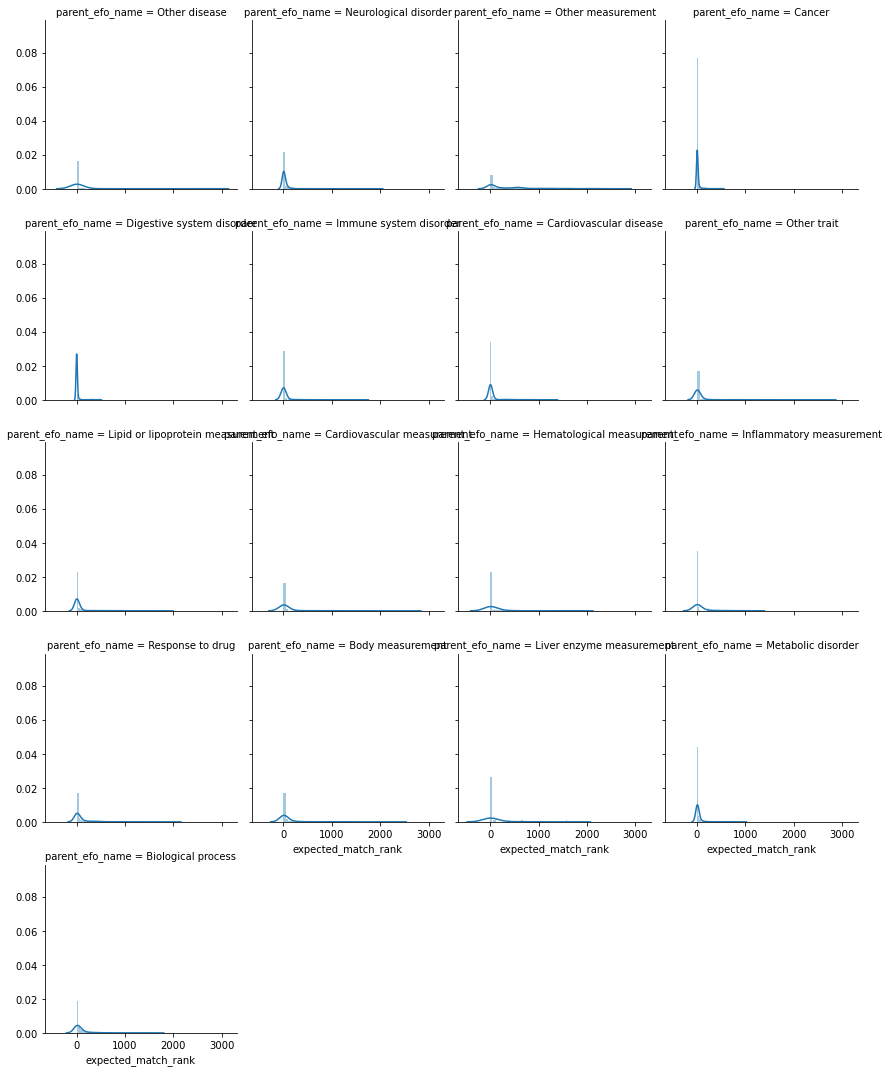

In [38]:
g = sns.FacetGrid(gwas_to_efo, col="parent_efo_name", col_wrap=4)
g.map(sns.distplot, "expected_match_rank")

In [40]:
s = gwas_to_efo[gwas_to_efo["parent_efo_name"] == "Cancer"]["expected_match_rank"]
print(len(s))
s.value_counts()

510


1     209
2      59
3      27
7      22
12     16
     ... 
48      1
46      1
44      1
43      1
42      1
Name: expected_match_rank, Length: 74, dtype: int64

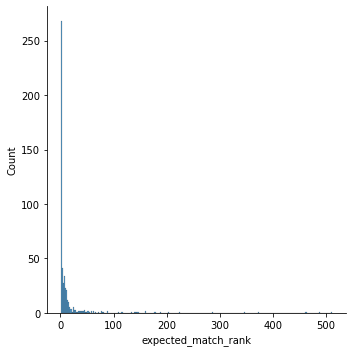

In [41]:
ax = sns.displot(s)

# percentage of expected match falling to top rank groups

In [52]:
def top_x(s, cutoff):
    return sum(s.apply(lambda x: x <= cutoff)) / len(s) * 100


top_ranks = (
    gwas_to_efo[["parent_efo_name", "expected_match_rank"]]
    .groupby("parent_efo_name")
    .agg(
        first_3=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=3),
        ),
        first_5=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=5),
        ),
        first_10=pd.NamedAgg(
            column="expected_match_rank", aggfunc=partial(top_x, cutoff=10),
        ),
    )
)
top_ranks

,first_3,first_5,first_10
parent_efo_name,,,
Biological process,36.802030,42.639594,48.477157
Body measurement,58.431373,61.176471,65.882353
Cancer,57.843137,63.529412,77.058824
Cardiovascular disease,62.889518,66.855524,74.787535
Cardiovascular measurement,52.816901,59.154930,67.957746
Digestive system disorder,78.971963,83.644860,89.252336
Hematological measurement,60.150376,66.917293,72.932331
Immune system disorder,73.408240,80.524345,85.393258
Inflammatory measurement,58.333333,66.666667,70.000000


# distances of top ranking terms to expected match term

TODO